# Posterior Estimation for ODEs

## Table of Contents
 * [Introduction](#introduction)
	 * [Analytical Solution](#analytical_solution)
	 * [Stability of Solutions](#stability_of_solutions)
 * [Generative Model Structure](#generative_model_structure)
 * [BayesFlow Architecture](#bayesflow_architecture)
	 * [Summary Network](#summary_network)
	 * [Inference Network](#inference_network)
 * [Preproccessing](#preproccessing)
 * [Training](#training)
 * [Validating the Results](#validating_the_results)
	 * [Latent Space Inspection](#latent_space_inspection)
	 * [Simulation-Based Calibration](#simulation_based_calibration)
	 * [Parameter Recoverability](#parameter_recoverability)
	 * [Individual Posteriors and Information Gain](#individual_posteriors_and)
	 * [Posterior Predictions (Re-Simulation)](#posterior_predictions__re_simulation_)

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

D:\Anaconda3\envs\TensorFlowDev\lib\site-packages\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Introduction <a class="anchor" id="introduction"></a>
In this tutorial, we will look at a simple linear ODE system:

$$
\frac{du}{dt} = a u + b v \\
\frac{dv}{dt} = c u + d v  
$$

with the boundary conditions:

$$
u(t=0) = u_0 \\
v(t=0) = v_0
$$

Given the solutions $u(t)$ and $v(t)$, we want to use BayesFlow to estimate the parameters $a$, $b$, $c$ and $d$ of the ODE equations as well as the boundary conditions $u_0$ and $v_0$ over all possible solutions of the system.

### Analytical Solution <a class="anchor" id="analytical_solution"></a>

The advantage of such a simple ODE system is, that the analytical solutions for $u$ and $v$ are known:

$$
\begin{pmatrix}
    u \\
    v
\end{pmatrix}
= C_1 e^{\lambda_1 t} \vec{v_1} + C_2 e^{\lambda_2 t} \vec{v_2} = 
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}
\begin{pmatrix}
    C_1 e^{\lambda_1 t} \\
    C_2 e^{\lambda_2 t}
\end{pmatrix}
$$

where $\lambda_1$ and $\lambda_2$ are eigenvalues and $\vec{v_1}$ and $\vec{v_2}$ are the corresponding eigenvectors of the matrix:

$$
A=
\begin{pmatrix}
    a & b \\
    c & d \\
\end{pmatrix}
$$

Note, that $\begin{bmatrix} \vec{v_1} & \vec{v_2} \end{bmatrix}$ is the matrix with eigenvectors $\vec{v_1}$ and $\vec{v_2}$ as its column vectors.
The constants $C_1$ and $C_2$ can be computed from the boundary condition:

$$
\begin{pmatrix}
    C_1 \\
    C_2
\end{pmatrix}
=
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}^{-1}
\begin{pmatrix}
    u_0 \\
    v_0
\end{pmatrix}
$$

### Stability of Solutions <a class="anchor" id="stability_of_solutions"></a>

The solution $u$ and $v$ will be of the form:

$$
u = v_{11} C_1 e^{\lambda_1 t} + v_{21} C_2 e^{\lambda_2 t} \\
v = v_{12} C_1 e^{\lambda_1 t} + v_{22} C_2 e^{\lambda_2 t}
$$

By separating the real and complex part of the eigenvalues $\lambda_j = \gamma + i \omega$ we see that the real part determines whether a solution will be exponential (increasing/decreasing) or stay constant, whereas the complex part will determine the oscillation behaviour. 

$$
u = v_{11} C_1 e^{\gamma_1 t} \left[ \cos(\omega_1 t) + i \sin(\omega_1 t) \right] + v_{21} C_2 e^{\gamma_2 t} \left[ \cos(\omega_2 t) + i \sin(\omega_2 t) \right] \\
v = v_{12} C_1 e^{\gamma_1 t} \left[ \cos(\omega_1 t) + i \sin(\omega_1 t) \right] + v_{22} C_2 e^{\gamma_2 t} \left[  \cos(\omega_2 t) + i \sin(\omega_2 t) \right]
$$

We will apply rejection sampling to only consider stable solutions. In other words, we only keep solutions that fulfill the condition $\gamma_1 \leq 0$ and $\gamma_2 \leq 0$.  

## Generative Model Structure <a class="anchor" id="generative_model_structure"></a>
 
We have to generate some simulated data to train our BayesFlow architecture. The first step is to randomly draw combinations of $a$, $b$, $c$, $d$, $u_0$ and $v_0$ from a uniform prior distribution. By computing the eigenvalues, we can preemptively reject prior samples that will lead to unstable solutions. Note, that this will also change the prior. Additionally, we estimate the prior means and standard deviations for standardization later. The standardization step is just a convenience, since neural networks like well-scaled data.

In [3]:
def model_prior():
    """Generates random draws from uniform pior with rejection sampling."""

    while True:
        sample = np.random.uniform(low=-10, high=10, size=6)
        A = sample[:4].reshape((2, 2))
        eigenvalues, _ = np.linalg.eig(A)
        if eigenvalues[0].real <= 0 and eigenvalues[1].real <= 0:
            break
    return sample

We wrap the prior function into the `Prior` wrapper:

In [4]:
prior = Prior(prior_fun=model_prior, param_names=[r"$a$", r"$b$", r"$c$", r"$d$", r"$u_0$", r"$v_0$"])
prior_means, prior_stds = prior.estimate_means_and_stds()

The next step is to generate simulated data using the prior samples by defining a simulator using the `Simulator` wrapper:

In [5]:
def linear_ode_solver(params, t):
    """Solves the linear ODE system analytically for given time points t and prior parameter draws."""

    # unpack params
    A = params[:4].reshape((2, 2))
    boundaries = params[-2:]

    # solve for u and v
    eigenvalues, eigenvectors = np.linalg.eig(A)
    C = np.linalg.inv(eigenvectors) @ boundaries
    solution = eigenvectors @ np.array([C[0] * np.exp(eigenvalues[0] * t), C[1] * np.exp(eigenvalues[1] * t)])

    return solution.T.real

In [6]:
time_points = np.linspace(0, 1, num=32)
simulator = Simulator(simulator_fun=partial(linear_ode_solver, t=time_points))

Finally, we will wrap the prior and simulator into a `GenerativeModel` which will connect the prior with the simulator:

In [7]:
model = GenerativeModel(prior, simulator, name="linear_ODE_generator")

INFO:root:Performing 2 pilot runs with the linear_ODE_generator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 32, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


As a sanity check, we can sample 1000 prior combinations and visualize the joint priors in bivariate plots. Note, that we have applied rejection sampling. Therefore, certain combinations of $a$, $b$, $c$, $d$ will always be rejected, because they will produce unstable solutions, so the priors are no longer uniform. You could inspect bivariate prior plots by calling the `plot_prior2d()` method of the prior object. We can also visualize some simulated trajectories:

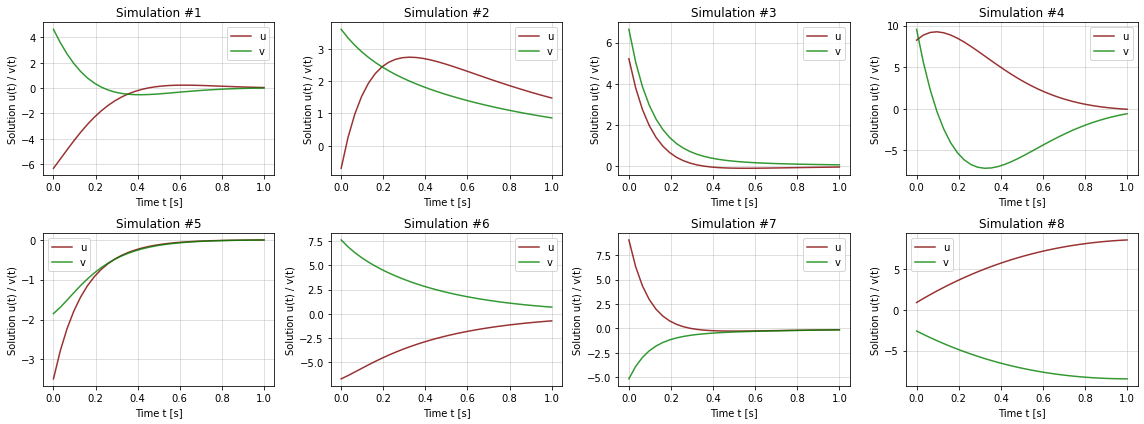

In [8]:
sim_data = model(8)["sim_data"]
fig, axarr = plt.subplots(2, 4, figsize=(16, 6))
ax = axarr.flat

for i, data in enumerate(sim_data):
    ax[i].plot(time_points, data[:, 0], label="u", color="maroon", alpha=0.8)
    ax[i].plot(time_points, data[:, 1], label="v", color="green", alpha=0.8)
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution u(t) / v(t)")
    ax[i].grid(alpha=0.5)
    ax[i].legend()
    ax[i].set_title(f"Simulation #{i+1}")

plt.tight_layout()
plt.show()

## BayesFlow Architecture <a class="anchor" id="bayesflow_architecture"></a>


The BayesFlow architecture consists of a summary network and an invertible neural network. The summary network learns summary statistics for each input, such that the summary network output will have dimensions `(batch_size, summary_dim)`. The invertible inference neural network is conditioned on the summary statistic of the summary network. 

### Summary Network <a class="anchor" id="summary_network"></a>

For this tutorial, we will use a small `LSTM` summary network followed by two `Dense` layers.

In [9]:
class CustomLSTM(tf.keras.Model):
    def __init__(self, hidden_size=128, summary_dim=32):
        super().__init__()
        self.LSTM = tf.keras.Sequential(
            [
                tf.keras.layers.LSTM(hidden_size),
                tf.keras.layers.Dense(hidden_size, activation="relu"),
                tf.keras.layers.Dense(summary_dim, activation="elu"),
            ]
        )

    def call(self, x, **kwargs):
        out = self.LSTM(x)
        return out

In [10]:
summary_net = CustomLSTM()

### Inference Network <a class="anchor" id="inference_network"></a>

For the inference network, we will use a 8-layer conditional invertible neural network (cINN):

In [11]:
COUPLING_NET_SETTINGS = {
    "dense_args": dict(units=128, kernel_regularizer=None, activation="relu"),
    "num_dense": 2,
    "dropout": False,
}

inference_net = InvertibleNetwork(num_params=6, num_coupling_layers=5, coupling_settings=COUPLING_NET_SETTINGS)

Finally, we wrap the summary network and inference network into an `AmortizedPosterior` instance:

In [12]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="linear_ODE_amortizer")

## Preproccessing <a class="anchor" id="preproccessing"></a>

Before we feed the simulation data to our BayesFlow amortizer, we want to perform some preprocessing such as normalization, logscale conversion for stability, and removing nan/infinite samples.

In [13]:
data = model(batch_size=1000)
sim_mean = np.mean(data["sim_data"])
sim_std = np.std(data["sim_data"])


def configure_input(forward_dict):
    """Configures dictionary of prior draws and simulated data into BayesFlow format."""

    out_dict = {}

    # standardization sim_data
    sim_data = forward_dict["sim_data"].astype(np.float32)
    norm_data = (sim_data - sim_mean) / sim_std

    # standardization priors
    params = forward_dict["prior_draws"].astype(np.float32)
    norm_params = (params - prior_means) / prior_stds

    # remove nan, inf and -inf
    keep_idx = np.all(np.isfinite(norm_data), axis=(1, 2))
    if not np.all(keep_idx):
        print("Invalid value encountered...removing from batch")

    # add to dict
    out_dict["summary_conditions"] = norm_data[keep_idx]
    out_dict["parameters"] = norm_params[keep_idx]

    return out_dict

## Training <a class="anchor" id="training"></a>

To train our BayesFlow amortizer, we first have to define a `Trainer` instance, which will take care of simulation-based training. Note, that we also use a piecewise constant decay learning rate scheduler to reduce the learning rate after a pre-selected number of training steps.

In order to save the networks, you can specify a `checkpoint_path` argument (networks will be saved after each epoch) or manually call the `save_weights` method of the `AmortizedPosterior` following training.

In [14]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Once we initialized the Trainer instance and run a consistency check on a test batch, we can print the number of trainable and non-trainable parameters in our BayesFlow model:

In [15]:
amortizer.summary()

Model: "linear_ODE_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 430260    
 bleNetwork)                                                     
                                                                 
 custom_lstm (CustomLSTM)    multiple                  87712     
                                                                 
Total params: 517,972
Trainable params: 517,912
Non-trainable params: 60
_________________________________________________________________


Now, we can train our BayesFlow architecture using online learning and showcasing a custom optimizer. 
<br><br>
Note: For the purpose of this tutorial, we tried to restrict notebook runtime to around 15min (using Ryzen 7 and Nvidia GTX 1080). Better results with lower uncertainties can be achieved by increasing the number of training iterations and the representation capacities of both summary and inference network. 

In [17]:
history = trainer.train_online(epochs=30, iterations_per_epoch=1000, batch_size=32)

We can visualize the training loss trajctory to inspect whether the networks have converged.

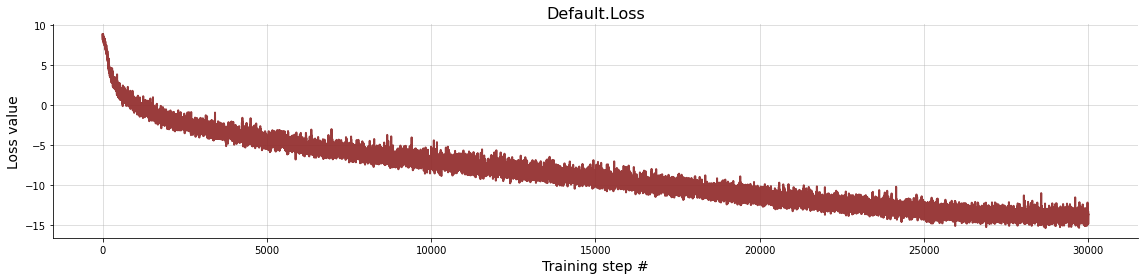

In [18]:
fig = diag.plot_losses(history)

## Validating the Results <a class="anchor" id="validating_the_results"></a>

After training our BayesFlow architecture, we want to validate the results. Our first step is to inspect the latent space $z$, which we enforce to be Gaussian using the default Kullback-Leibler (KL) loss during training.

### Latent Space Inspection <a class="anchor" id="latent_space_inspection"></a>


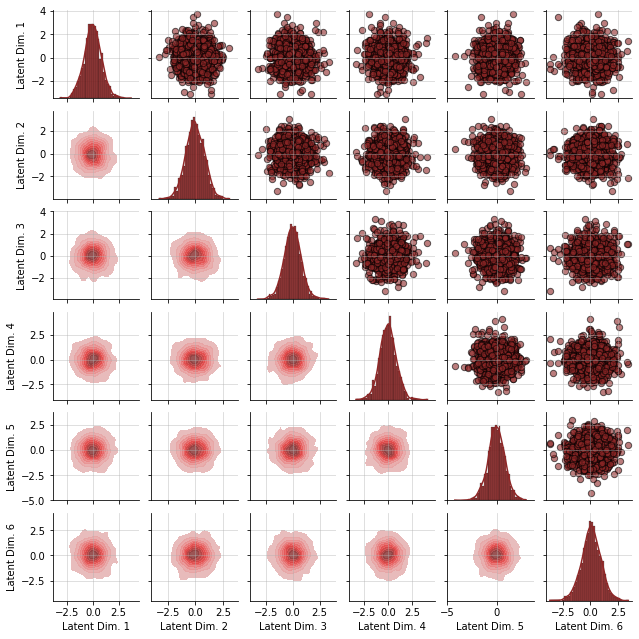

In [19]:
fig = trainer.diagnose_latent2d(plot_args={"height": 1.5})

### Simulation-Based Calibration <a class="anchor" id="simulation_based_calibration"></a>


Next we can perform simulation-based calibration (SBC) as proposed by [Talts et al. (2020)](https://arxiv.org/pdf/1804.06788.pdf):

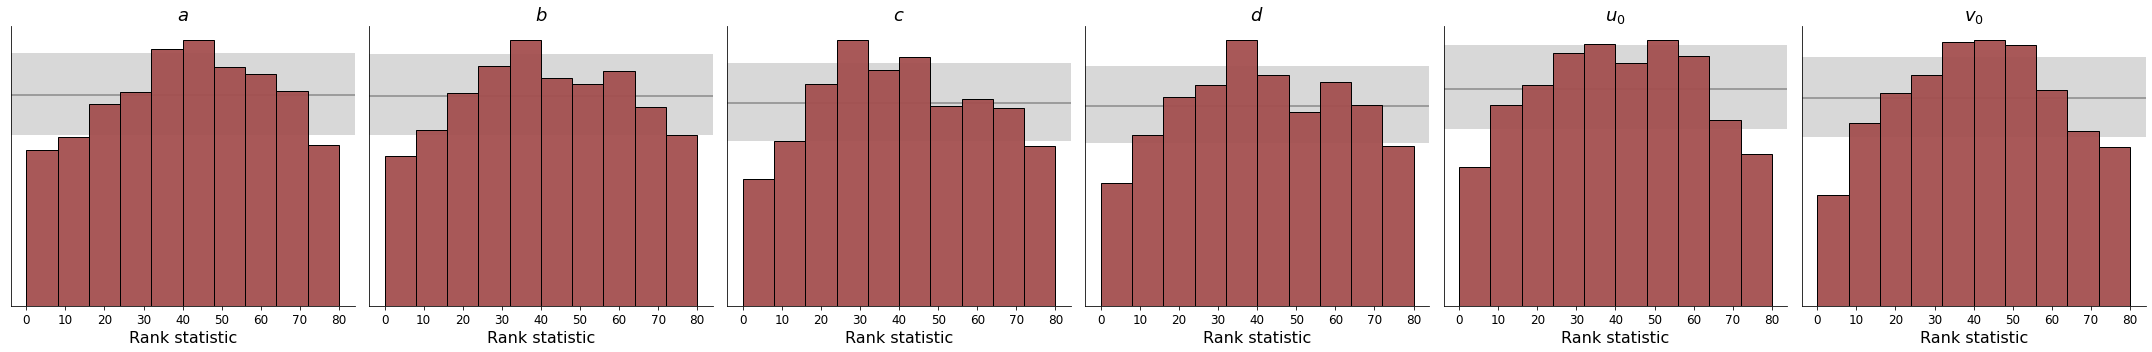

In [20]:
fig = trainer.diagnose_sbc_histograms()

Additionally, we can also inspect the simulation-based calibration through empirical cumulative distribution functions (ECDF) instead of histograms as proposed by [Säilynoja et al. (2021)](https://arxiv.org/pdf/2103.10522.pdf):

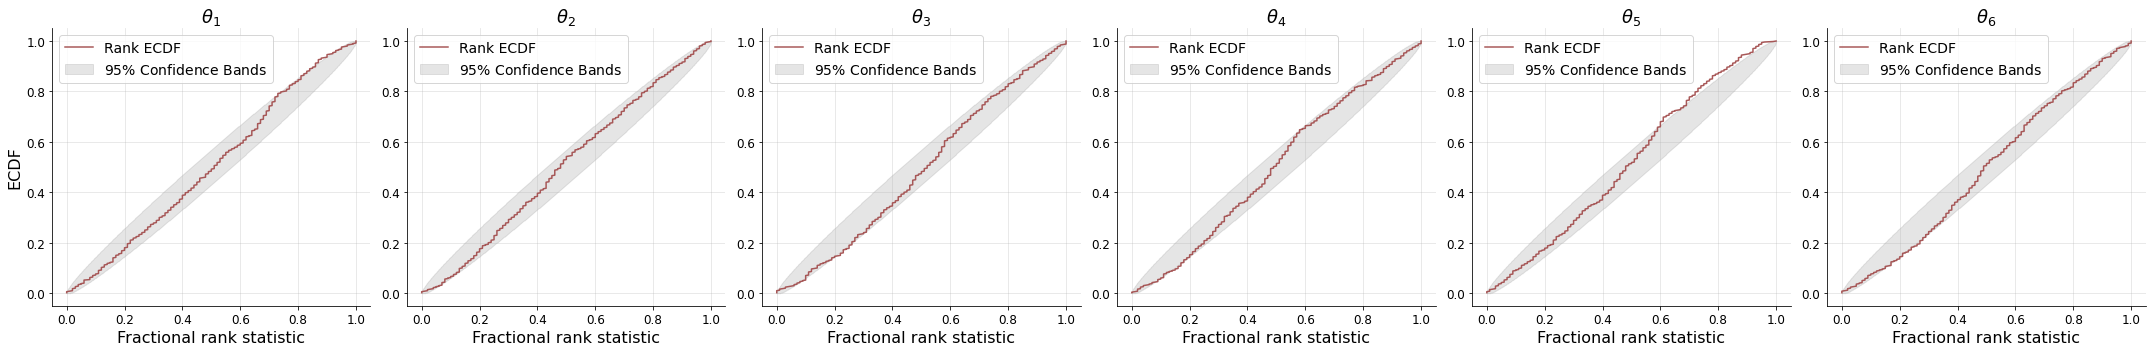

In [29]:
valid_sim_data_raw = model(batch_size=500)
valid_sim_data = trainer.configurator(valid_sim_data_raw)
posterior_samples = amortizer.sample(valid_sim_data, n_samples=100)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data["parameters"])

Most imporantly, the SBC diagnostic is **interpretable**. The slightly bell-shaped histograms and slightly sigmoid-like ECDFs suggest that the posteriors are *underconfident*, that is, they do not achieve the optimal uncertainty reduction. You can train longer and see how this underconfidence gradually disappears.

### Parameter Recoverability <a class="anchor" id="parameter_recoverability"></a>


During inference, BayesFlow will provide us with a posterior distribution for every hidden parameter and every possible solution. To get a point estimate from BayesFlow, we will simply take the mean value of the posterior. For validation, we can plot the posterior mean value against the ground truth and compute the R Squared for our model. In the ideal case, all predicted values should lie on the diagonal line (posterior standard deviations are also plotted for an uncertainty measure): 

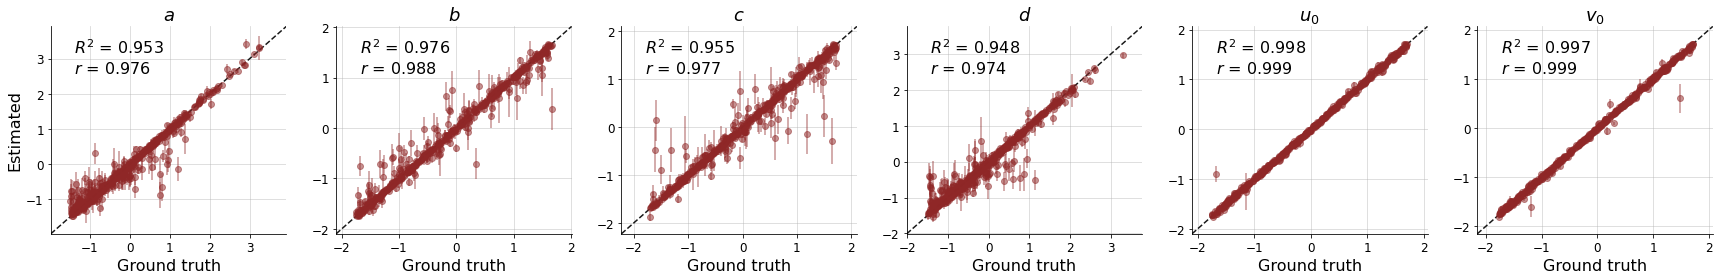

In [30]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data["parameters"], param_names=prior.param_names)

### Individual Posteriors and Information Gain <a class="anchor" id="individual_posteriors_and"></a>


For single solutions, we can also visualize the bivariate posteriors for all hidden parameters and compare them to their corresponding priors. This is a quick way to gather how much information gain (equiv. uncertainty reduction) we have achieved by replacing the prior with the posterior. Naturally, due to the simplicity of our forward model, the information gain is enormous.

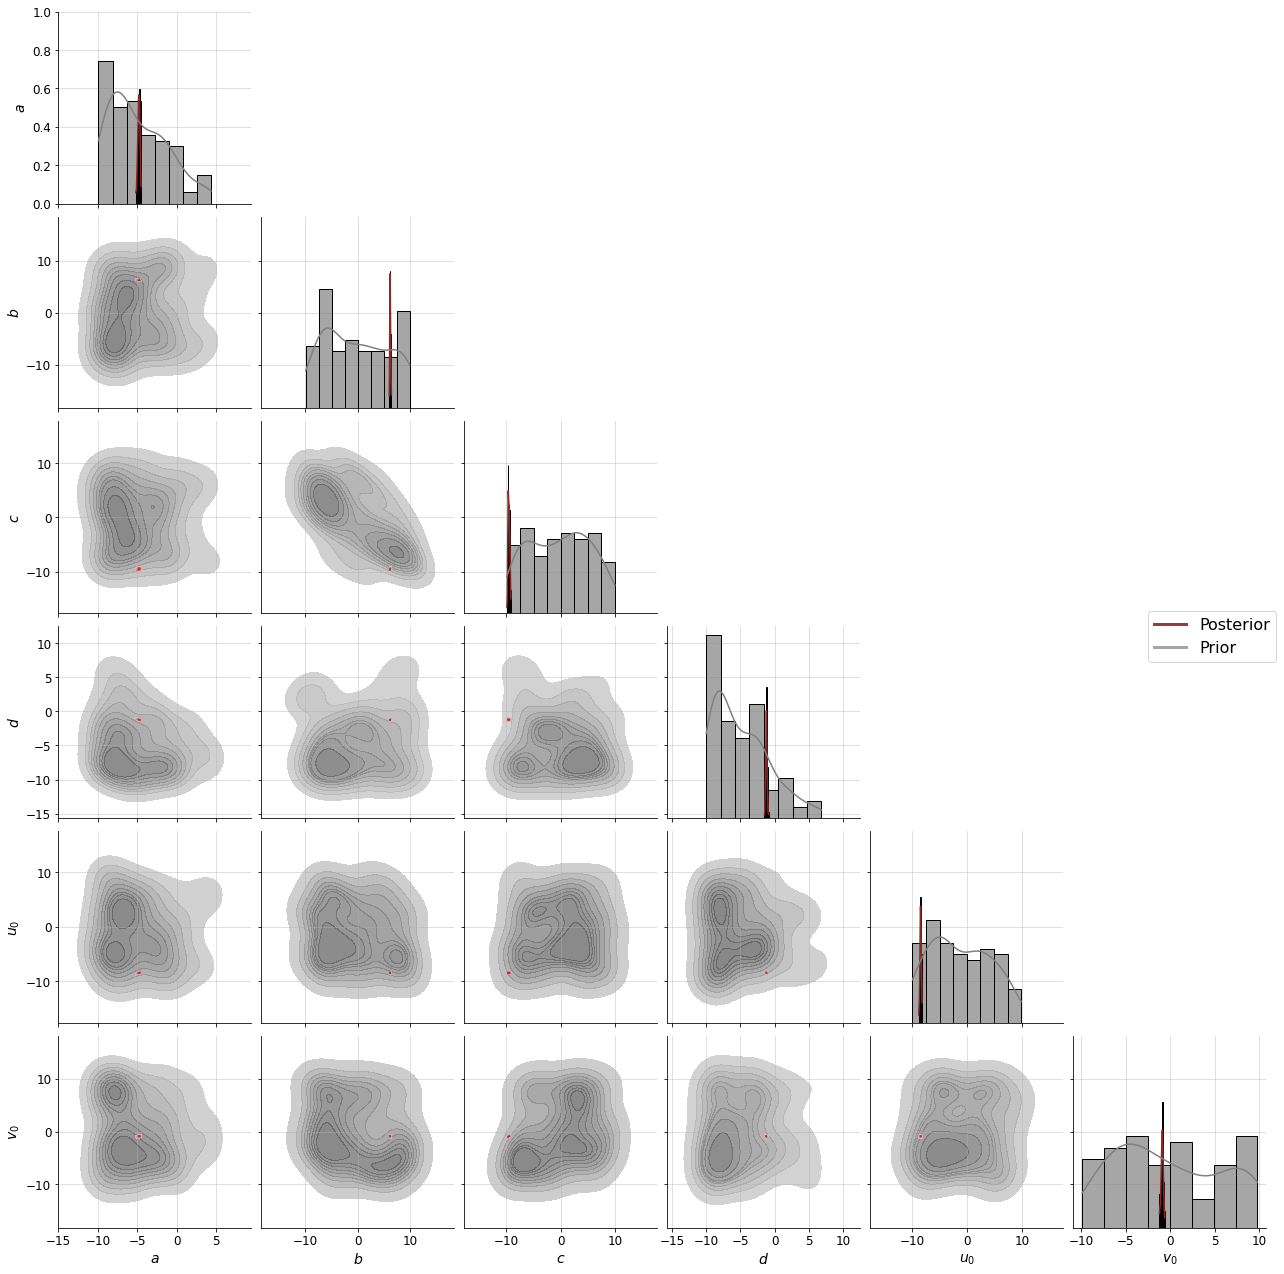

In [31]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior)

### Posterior Predictions (Re-Simulation) <a class="anchor" id="posterior_predictions__re_simulation_"></a>


The last check we will perform here is re-simulation (also known as posterior predictive checks or generative performance). Given a set of linear ODE solutions of $u(t)$ and $v(t)$, we predict the posterior of $a$, $b$, $c$, $d$, $u_0$ and $v_0$. All parameter posterior samples will then be passed to the simulator to re-simulate $\hat{u}_i(t)$ and $\hat{v}_i(t)$. Finally, we compute the median and quantile between all $\hat{u}_i(t)$ and $\hat{v}_i(t)$ and compare to the ground truth solutions $u(t)$ and $v(t)$:

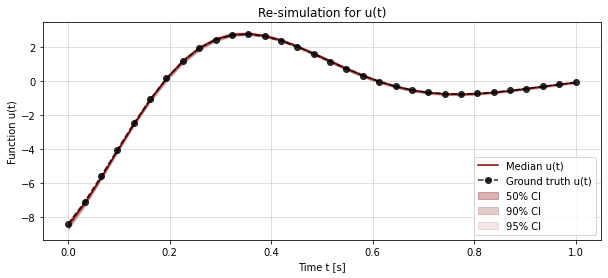

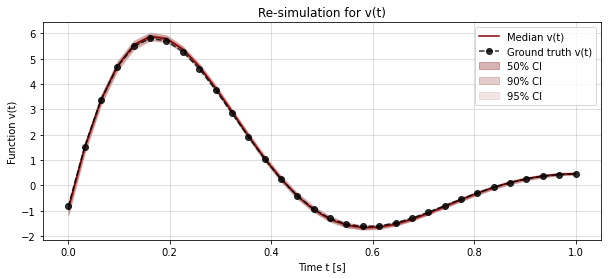

In [32]:
# re-simulation
resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)
resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)

for i in range(posterior_samples_unnorm[0].shape[0]):
    re_sim = linear_ode_solver(posterior_samples_unnorm[0, i], time_points)
    resim_u[i, :] = re_sim[:, 0]
    resim_v[i, :] = re_sim[:, 1]

# compute quantiles
u_qt_50 = np.quantile(resim_u, q=[0.25, 0.75], axis=0)
u_qt_90 = np.quantile(resim_u, q=[0.05, 0.95], axis=0)
u_qt_95 = np.quantile(resim_u, q=[0.025, 0.975], axis=0)
v_qt_50 = np.quantile(resim_v, q=[0.25, 0.75], axis=0)
v_qt_90 = np.quantile(resim_v, q=[0.05, 0.95], axis=0)
v_qt_95 = np.quantile(resim_v, q=[0.025, 0.975], axis=0)

# plot u
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(time_points, np.median(resim_u, axis=0), label="Median u(t)", color="maroon")
ax.plot(
    time_points,
    valid_sim_data_raw["sim_data"][0, :, 0],
    marker="o",
    label="Ground truth u(t)",
    color="k",
    linestyle="--",
    alpha=0.8,
)
ax.fill_between(time_points, u_qt_50[0], u_qt_50[1], color="maroon", alpha=0.3, label="50% CI")
ax.fill_between(time_points, u_qt_90[0], u_qt_90[1], color="maroon", alpha=0.2, label="90% CI")
ax.fill_between(time_points, u_qt_95[0], u_qt_95[1], color="maroon", alpha=0.1, label="95% CI")
ax.grid(alpha=0.5)
ax.set_title("Re-simulation for u(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function u(t)")
ax.legend()
plt.show()

# plot v
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(time_points, np.median(resim_v, axis=0), label="Median v(t)", color="maroon")
ax.plot(
    time_points,
    valid_sim_data_raw["sim_data"][0, :, 1],
    marker="o",
    label="Ground truth v(t)",
    color="k",
    linestyle="--",
    alpha=0.8,
)
ax.fill_between(time_points, v_qt_50[0], v_qt_50[1], color="maroon", alpha=0.3, label="50% CI")
ax.fill_between(time_points, v_qt_90[0], v_qt_90[1], color="maroon", alpha=0.2, label="90% CI")
ax.fill_between(time_points, v_qt_95[0], v_qt_95[1], color="maroon", alpha=0.1, label="95% CI")
ax.grid(alpha=0.5)
ax.set_title("Re-simulation for v(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function v(t)")
ax.legend()
plt.show()

These results are pretty good, depending on the tolerable error for a given application. You should now be able to apply BayesFlow to your own dynamic models!